In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt

In [36]:
# Load datasets
data_2010_2019 = pd.read_csv('/content/nifty50_2010_2019.csv', index_col='Date', parse_dates=True)
data_6_weeks = pd.read_csv('/content/nifty50_6_weeks.csv', index_col='Date', parse_dates=True)

# Check and remove NaN values
data_2010_2019.dropna(inplace=True)
data_6_weeks.dropna(inplace=True)

In [37]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_2010_2019 = scaler.fit_transform(data_2010_2019[['Close']])
scaled_data_6_weeks = scaler.fit_transform(data_6_weeks[['Close']])

In [38]:
# Split the data into train and test sets
train_size = int(len(scaled_data_2010_2019) * 0.8)
train_data = scaled_data_2010_2019[:train_size]
test_data = scaled_data_2010_2019[train_size:]

In [39]:
# Create a dataset function
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        if i + time_step < len(dataset):
            Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [40]:
# Use a longer time_step
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
# Improve ARIMA model using auto_arima
arima_model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)
arima_fit = arima_model.fit(train_data)

# Forecasting with ARIMA
arima_forecast = arima_fit.predict(n_periods=len(test_data))
arima_forecast = scaler.inverse_transform(arima_forecast.reshape(-1, 1))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12326.447, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12320.682, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12329.124, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12329.849, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12319.843, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12329.918, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12327.546, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12327.590, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12329.629, Time=2.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12329.391, Time=1.83 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12329.351, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.441 seconds


In [44]:
# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(100, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min')

lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=[early_stop, checkpoint])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.5493e-04 - val_loss: 9.8687e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0213e-04 - val_loss: 5.5813e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0633e-04 - val_loss: 5.7257e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6603e-04 - val_loss: 4.8240e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0443e-04 - val_loss: 0.0030
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5345e-04 - val_loss: 0.0019
Epoch 12/100
57/

In [46]:
# Load the best LSTM model
lstm_model.load_weights('best_lstm_model.keras')

# Predict with LSTM and inverse transform
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [47]:
# Evaluate models
def sharpe_ratio(returns, risk_free_rate=0.01):
    return (np.mean(returns) - risk_free_rate) / np.std(returns)

def max_drawdown(returns):
    cumulative = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return np.min(drawdown)

arima_returns = np.diff(arima_forecast.flatten()) / arima_forecast[:-1].flatten()
lstm_returns = np.diff(lstm_predictions.flatten()) / lstm_predictions[:-1].flatten()

arima_sharpe = sharpe_ratio(arima_returns)
lstm_sharpe = sharpe_ratio(lstm_returns)

print(f'ARIMA Sharpe Ratio: {arima_sharpe}')
print(f'LSTM Sharpe Ratio: {lstm_sharpe}')

ARIMA Sharpe Ratio: -26652.51079910828
LSTM Sharpe Ratio: -58.49323775555794


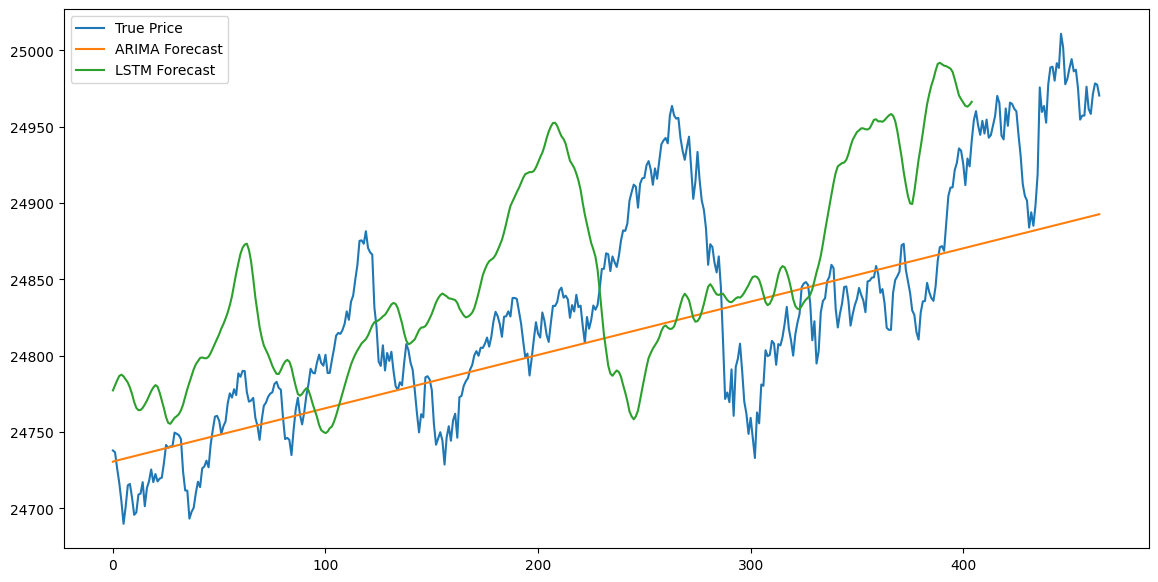

In [48]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(test_data), label='True Price')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(lstm_predictions, label='LSTM Forecast')
plt.legend()
plt.show()

In [50]:
# Gym environment for trading
class StockTradingEnv(Env):
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.action_space = Discrete(3)  # 0: Buy, 1: Hold, 2: Sell
        self.observation_space = Box(low=0, high=1, shape=(1,))
        self.current_step = 0
        self.done = False
        self.balance = 10000
        self.shares = 0
        self.total_asset = self.balance

    def reset(self):
        self.current_step = 0
        self.done = False
        self.balance = 10000
        self.shares = 0
        self.total_asset = self.balance
        return [self.data[self.current_step]]

    def step(self, action):
        if self.done:
            return [self.data[self.current_step - 1]], 0, self.done, {}

        current_price = self.data[self.current_step]
        if current_price <= 0 or np.isnan(current_price):
            self.done = True
            return [self.data[self.current_step]], 0, self.done, {}

        if action == 0:
            num_shares_to_buy = self.balance // current_price
            if num_shares_to_buy > 0:
                self.shares += num_shares_to_buy
                self.balance -= num_shares_to_buy * current_price
        elif action == 2:
            self.balance += self.shares * current_price
            self.shares = 0

        self.total_asset = self.balance + self.shares * current_price

        self.current_step += 1

        if self.current_step >= len(self.data):
            self.done = True

        reward = self.total_asset - (self.balance + self.shares * current_price)

        return [self.data[self.current_step - 1]], reward, self.done, {}

In [51]:
# Setup the environment
env = DummyVecEnv([lambda: StockTradingEnv(scaled_data_2010_2019.flatten())])
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=2000)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
------------------------------------
| time/                 |          |
|    fps                | 247      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.1     |
|    explained_variance | -0.216   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.1e-06 |
|    value_loss         | 1.15e-11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 317       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -1.1      |
|    explained_variance | -1.17     |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -5.51e-07 |
|    val

In [52]:
# Test the model with new data
obs = env.reset()
for i in range(len(test_data)):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

Shape of X_test_tbp before reshaping: (29, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


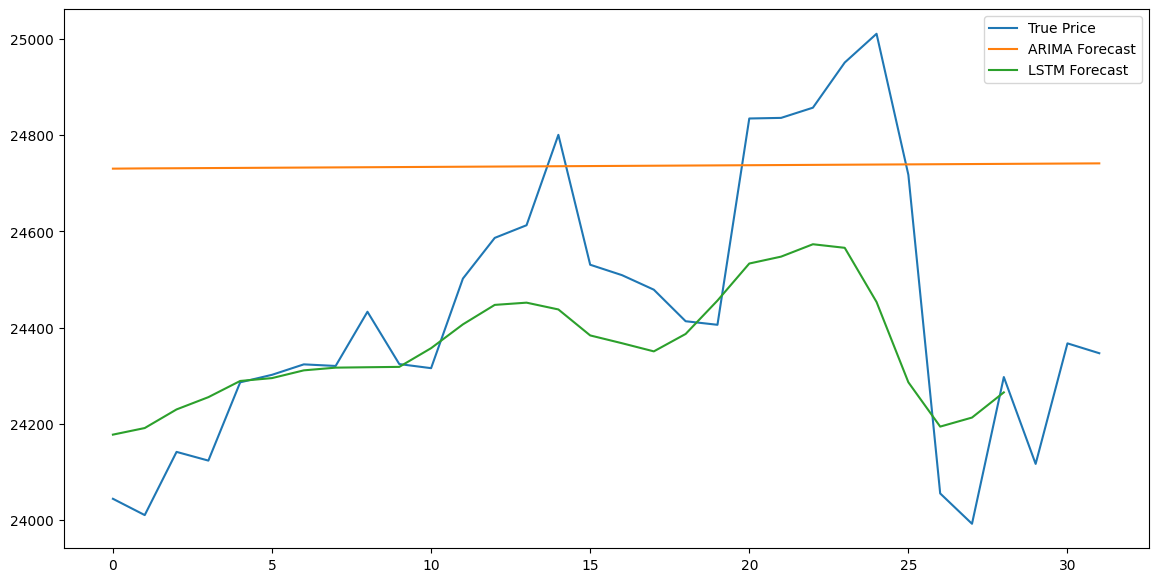

ARIMA Sharpe Ratio: -6985.606253394086
LSTM Sharpe Ratio: -4.569915013489264


In [55]:
# Define a smaller time step if the dataset is small
time_step = max(1, len(scaled_data_tbp) // 10)  # Adjust the factor based on dataset size

# Create the test dataset with the new time_step
X_test_tbp, y_test_tbp = create_dataset(scaled_data_tbp, time_step)

# Debug: Print shapes to see if they are as expected
print("Shape of X_test_tbp before reshaping:", X_test_tbp.shape)

if X_test_tbp.shape[0] > 0:
    X_test_tbp = X_test_tbp.reshape(X_test_tbp.shape[0], X_test_tbp.shape[1], 1)
    # Continue if the shape is correct
    arima_forecast = arima_fit.predict(n_periods=len(scaled_data_tbp))
    arima_forecast = scaler.inverse_transform(arima_forecast.reshape(-1, 1))

    lstm_predictions = lstm_model.predict(X_test_tbp)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Plot the new results
    plt.figure(figsize=(14, 7))
    plt.plot(scaler.inverse_transform(scaled_data_tbp), label='True Price')
    plt.plot(arima_forecast, label='ARIMA Forecast')
    plt.plot(lstm_predictions, label='LSTM Forecast')
    plt.legend()
    plt.show()

    # Evaluate the Sharpe Ratios for the new data
    arima_returns = np.diff(arima_forecast.flatten()) / arima_forecast[:-1].flatten()
    lstm_returns = np.diff(lstm_predictions.flatten()) / lstm_predictions[:-1].flatten()

    arima_sharpe = sharpe_ratio(arima_returns)
    lstm_sharpe = sharpe_ratio(lstm_returns)

    print(f'ARIMA Sharpe Ratio: {arima_sharpe}')
    print(f'LSTM Sharpe Ratio: {lstm_sharpe}')
else:
    print("X_test_tbp is empty after attempting to reshape.")